In [9]:
#!pip install python-chess

In [2]:
import os
import zipfile
import pandas as pd
import chess.pgn
from io import TextIOWrapper

# === Configuración ===
zip_folder = "pgns"
os.makedirs("pgns_extracted", exist_ok=True)  # No usado, pero por si luego se quiere guardar
game_counter = 0

# === Contenedores de resultados ===
all_games_info = []
player_moves_data = []

# === Proceso de extracción ===
for zip_name in sorted(os.listdir(zip_folder)):
    if not zip_name.endswith(".zip"):
        continue

    player_lastname = os.path.splitext(zip_name)[0]  # "Carlsen", "Kasparov", etc.
    zip_path = os.path.join(zip_folder, zip_name)

    with zipfile.ZipFile(zip_path, 'r') as archive:
        for pgn_filename in archive.namelist():
            if not pgn_filename.endswith(".pgn"):
                continue

            with archive.open(pgn_filename) as file:
                text_io = TextIOWrapper(file, encoding='utf-8', errors='ignore')
                while True:
                    game = chess.pgn.read_game(text_io)
                    if game is None:
                        break

                    board = game.board()
                    moves = []
                    for move in game.mainline_moves():
                        try:
                            san = board.san(move)
                        except Exception:
                            san = None  # jugada inválida
                        if san:
                            moves.append(san)
                        board.push(move)

                    white = game.headers.get("White", "").lower()
                    black = game.headers.get("Black", "").lower()
                    lastname_lower = player_lastname.lower()

                    # Determinar si el jugador del archivo es blanco o negro
                    if lastname_lower in white:
                        player_color = "white"
                        player_moves = moves[::2]
                    elif lastname_lower in black:
                        player_color = "black"
                        player_moves = moves[1::2]
                    else:
                        continue  # Si el jugador no aparece como blanco ni negro, saltamos

                    # === Guardar en ambos dataframes ===
                    game_id = game_counter

                    all_games_info.append({
                        "id": game_id,
                        "event": game.headers.get("Event", ""),
                        "site": game.headers.get("Site", ""),
                        "date": game.headers.get("Date", ""),
                        "white": game.headers.get("White", ""),
                        "black": game.headers.get("Black", ""),
                        "result": game.headers.get("Result", ""),
                        "white_elo": game.headers.get("WhiteElo", ""),
                        "black_elo": game.headers.get("BlackElo", ""),
                        "eco": game.headers.get("ECO", ""),
                        "full_moves": " ".join(moves),
                        "player_file": player_lastname,
})

                    player_moves_data.append({
                        "id": game_id,
                        "player": player_lastname,
                        "color": player_color,
                        "moves": " ".join(player_moves),
                    })

                    game_counter += 1

# === Crear DataFrames ===
df_all_games = pd.DataFrame(all_games_info)
df_player_moves = pd.DataFrame(player_moves_data)


# === Guardar a CSV (opcional) ===
df_all_games.to_csv("csvs/games.csv", index=False)
df_player_moves.to_csv("csvs/player_moves.csv", index=False)


print(f"Partidas procesadas: {len(df_all_games)}")


illegal san: 'Qxe1' in r2k3r/2pPp3/p4n2/3b2B1/1p5P/2qP4/3RQ1P1/4K2R w - - 2 31 while parsing <Game at 0x20fab712450 ('Gelfand,B' vs. 'Gareev,T', '2019.12.29' at 'Moscow RUS')>


Partidas procesadas: 99897


In [3]:
df_all_games

,id,event,site,date,white,black,result,white_elo,black_elo,eco,full_moves,player_file
0,0,Earl tourn,?,1906.??.??,Savrov,"Alekhine, Alexander",0-1,,,C30,e4 e5 f4 Bc5 Nf3 d6 c3 Bg4 Be2 Bxf3 Bxf3 Nc6 b...,Alekhine
1,1,Earl tourn,?,1906.??.??,Giese,"Alekhine, Alexander",0-1,,,C47,e4 e5 Nf3 Nc6 d4 exd4 Nxd4 Nf6 Nc3 Bb4 Nxc6 bx...,Alekhine
2,2,Earl tourn,?,1906.??.??,"Alekhine, Alexander","Ljubimov, T.",1-0,,,C58,e4 e5 Nf3 Nc6 Bc4 Nf6 Ng5 d5 exd5 Na5 Bb5+ c6 ...,Alekhine
3,3,Earl tourn,?,1906.??.??,"Alekhine, Alexander",Romaskevic,1-0,,,C20,e4 e5 Ne2 f5 Ng3 Qh4 Nc3 Bc5 Qf3 d6 exf5 Ne7 N...,Alekhine
4,4,Earl tourn,?,1906.??.??,"Manko, V.","Alekhine, Alexander",1-0,,,C52,e4 e5 Nf3 Nc6 Bc4 Bc5 b4 Bxb4 c3 Ba5 d4 exd4 O...,Alekhine
...,...,...,...,...,...,...,...,...,...,...,...,...
99892,99892,London m,London,1887.??.??,"Zukertort, Johannes Hermann","Blackburne, Joseph Henry",0-1,,,D30,d4 d5 e3 Nf6 c4 e6 Nf3 c5 b3 Nc6 Bb2 cxd4 exd4...,Zukertort
99893,99893,London m,London,1887.??.??,"Blackburne, Joseph Henry","Zukertort, Johannes Hermann",1/2-1/2,,,C66,e4 e5 Nf3 Nc6 Bb5 Nf6 d3 d6 O-O g6 Nc3 Bd7 Bg5...,Zukertort
99894,99894,London m,London,1887.??.??,"Zukertort, Johannes Hermann","Blackburne, Joseph Henry",1/2-1/2,,,A20,c4 e5 e3 Nc6 a3 g6 Nc3 Bg7 Nf3 Nge7 Be2 d5 cxd...,Zukertort
99895,99895,London m,London,1887.??.??,"Blackburne, Joseph Henry","Zukertort, Johannes Hermann",1/2-1/2,,,D26,d4 d5 c4 e6 Nc3 Nf6 Bf4 c5 e3 Nc6 Nf3 cxd4 exd...,Zukertort


In [4]:
df_player_moves

,id,player,color,moves
0,0,Alekhine,black,e5 Bc5 d6 Bg4 Bxf3 Nc6 Bb6 Nce7 exd4 Nf6 O-O d...
1,1,Alekhine,black,e5 Nc6 exd4 Nf6 Bb4 bxc6 Qe7 d5 O-O Bc5 gxf6 B...
2,2,Alekhine,white,e4 Nf3 Bc4 Ng5 exd5 Bb5+ dxc6 Qf3 Bd3 Ne4 Ng3 ...
3,3,Alekhine,white,e4 Ne2 Ng3 Nc3 Qf3 exf5 Nce4 c3 d4 Nh5 Nhf6+ g...
4,4,Alekhine,black,e5 Nc6 Bc5 Bxb4 Ba5 exd4 dxc3 Qf6 Qg6 Nge7 Rb8...
...,...,...,...,...
99892,99892,Zukertort,white,d4 e3 c4 Nf3 b3 Bb2 exd4 bxc4 Nbd2 Qa4 Rd1 Bd3...
99893,99893,Zukertort,black,e5 Nc6 Nf6 d6 g6 Bd7 Bg7 h6 Bxf6 Bg7 O-O Ne7 N...
99894,99894,Zukertort,white,c4 e3 a3 Nc3 Nf3 Be2 cxd5 O-O Qc2 bxc3 d3 e4 h...
99895,99895,Zukertort,black,d5 e6 Nf6 c5 Nc6 cxd4 dxc4 Be7 O-O Bd7 Rc8 Qa5...


In [ ]:
df_player_moves["player"].value_counts()

player
Kamsky         7035
Carlsen        6615
Caruana        5340
Aronian        5107
Ivanchuk       4950
Kramnik        4324
Anand          4204
Gelfand        3983
Timman         3621
Karjakin       3536
Karpov         3529
Portisch       3030
Leko           2681
Smyslov        2627
Topalov        2613
Tal            2431
Larsen         2383
Spassky        2231
Geller         2198
Kasparov       2128
Bronstein      1930
Petrosian      1893
Polugaevsky    1890
Alekhine       1661
Najdorf        1604
Keres          1571
Reshevsky      1267
Euwe           1122
Korchnoi       1038
Bogoljubow      973
Lasker          900
Botvinnik       891
Fischer         827
Rubinstein      797
Maroczy         756
Schlechter      739
Tarrasch        704
Chigorin        688
Anderssen       681
Capablanca      597
Steinitz        590
Nimzowitsch     512
Pillsbury       388
Fine            305
Staunton        284
Zukertort       265
Winawer         241
Morphy          211
Philidor          6
Name: count, 

Una vez listos los archivos base, los limpiamos y creamos los embeddings

In [1]:
import pandas as pd


In [2]:
df_player_moves = pd.read_csv("csvs/player_moves.csv")
df_player_moves

,id,player,color,moves
0,0,Alekhine,black,e5 Bc5 d6 Bg4 Bxf3 Nc6 Bb6 Nce7 exd4 Nf6 O-O d...
1,1,Alekhine,black,e5 Nc6 exd4 Nf6 Bb4 bxc6 Qe7 d5 O-O Bc5 gxf6 B...
2,2,Alekhine,white,e4 Nf3 Bc4 Ng5 exd5 Bb5+ dxc6 Qf3 Bd3 Ne4 Ng3 ...
3,3,Alekhine,white,e4 Ne2 Ng3 Nc3 Qf3 exf5 Nce4 c3 d4 Nh5 Nhf6+ g...
4,4,Alekhine,black,e5 Nc6 Bc5 Bxb4 Ba5 exd4 dxc3 Qf6 Qg6 Nge7 Rb8...
...,...,...,...,...
99892,99892,Zukertort,white,d4 e3 c4 Nf3 b3 Bb2 exd4 bxc4 Nbd2 Qa4 Rd1 Bd3...
99893,99893,Zukertort,black,e5 Nc6 Nf6 d6 g6 Bd7 Bg7 h6 Bxf6 Bg7 O-O Ne7 N...
99894,99894,Zukertort,white,c4 e3 a3 Nc3 Nf3 Be2 cxd5 O-O Qc2 bxc3 d3 e4 h...
99895,99895,Zukertort,black,d5 e6 Nf6 c5 Nc6 cxd4 dxc4 Be7 O-O Bd7 Rc8 Qa5...


In [3]:
#Valores nulos
df_player_moves.isna().sum()

id         0
player     0
color      0
moves     52
dtype: int64

In [4]:
#Eliminamos valores nulos
df_player_moves = df_player_moves.dropna(subset=["moves"]).copy()
df_player_moves["moves"] = df_player_moves["moves"].astype(str)
df_player_moves

,id,player,color,moves
0,0,Alekhine,black,e5 Bc5 d6 Bg4 Bxf3 Nc6 Bb6 Nce7 exd4 Nf6 O-O d...
1,1,Alekhine,black,e5 Nc6 exd4 Nf6 Bb4 bxc6 Qe7 d5 O-O Bc5 gxf6 B...
2,2,Alekhine,white,e4 Nf3 Bc4 Ng5 exd5 Bb5+ dxc6 Qf3 Bd3 Ne4 Ng3 ...
3,3,Alekhine,white,e4 Ne2 Ng3 Nc3 Qf3 exf5 Nce4 c3 d4 Nh5 Nhf6+ g...
4,4,Alekhine,black,e5 Nc6 Bc5 Bxb4 Ba5 exd4 dxc3 Qf6 Qg6 Nge7 Rb8...
...,...,...,...,...
99892,99892,Zukertort,white,d4 e3 c4 Nf3 b3 Bb2 exd4 bxc4 Nbd2 Qa4 Rd1 Bd3...
99893,99893,Zukertort,black,e5 Nc6 Nf6 d6 g6 Bd7 Bg7 h6 Bxf6 Bg7 O-O Ne7 N...
99894,99894,Zukertort,white,c4 e3 a3 Nc3 Nf3 Be2 cxd5 O-O Qc2 bxc3 d3 e4 h...
99895,99895,Zukertort,black,d5 e6 Nf6 c5 Nc6 cxd4 dxc4 Be7 O-O Bd7 Rc8 Qa5...


In [5]:
#Partidas con un solo movimiento
print(df_player_moves["moves"].apply(lambda x: len(str(x).split())).le(1).sum())
df_player_moves[df_player_moves["moves"].apply(lambda x: len(str(x).split())) <= 1].head()

27


,id,player,color,moves
6396,6396,Anderssen,white,d4
13607,13607,Bronstein,white,d4
14567,14567,Bronstein,white,e4
20445,20445,Carlsen,black,g5
21608,21608,Carlsen,black,h6


In [6]:
#Eliminamos partidas que tengan un solo movimiento
df_player_moves = df_player_moves[df_player_moves["moves"].apply(lambda x: len(str(x).split())) > 1]
df_player_moves

,id,player,color,moves
0,0,Alekhine,black,e5 Bc5 d6 Bg4 Bxf3 Nc6 Bb6 Nce7 exd4 Nf6 O-O d...
1,1,Alekhine,black,e5 Nc6 exd4 Nf6 Bb4 bxc6 Qe7 d5 O-O Bc5 gxf6 B...
2,2,Alekhine,white,e4 Nf3 Bc4 Ng5 exd5 Bb5+ dxc6 Qf3 Bd3 Ne4 Ng3 ...
3,3,Alekhine,white,e4 Ne2 Ng3 Nc3 Qf3 exf5 Nce4 c3 d4 Nh5 Nhf6+ g...
4,4,Alekhine,black,e5 Nc6 Bc5 Bxb4 Ba5 exd4 dxc3 Qf6 Qg6 Nge7 Rb8...
...,...,...,...,...
99892,99892,Zukertort,white,d4 e3 c4 Nf3 b3 Bb2 exd4 bxc4 Nbd2 Qa4 Rd1 Bd3...
99893,99893,Zukertort,black,e5 Nc6 Nf6 d6 g6 Bd7 Bg7 h6 Bxf6 Bg7 O-O Ne7 N...
99894,99894,Zukertort,white,c4 e3 a3 Nc3 Nf3 Be2 cxd5 O-O Qc2 bxc3 d3 e4 h...
99895,99895,Zukertort,black,d5 e6 Nf6 c5 Nc6 cxd4 dxc4 Be7 O-O Bd7 Rc8 Qa5...


In [7]:
#Partidas duplicadas
print(df_player_moves.duplicated(subset=["player", "moves"]).sum())
df_player_moves[df_player_moves.duplicated(subset=["player", "moves"])]

14


,id,player,color,moves
1046,1046,Alekhine,white,e4 Nf3 Bb5 Bxc6 d4 Qxd4 O-O exd5 Nc3 Qe5+ Re1 ...
1049,1049,Alekhine,white,e4 Nf3 Bb5 Ba4 O-O Re1 Bb3 a4 c3 Bc2 d3 Nbd2 N...
49212,49212,Karjakin,white,e4 Nf3 Bc4 c3 d4 O-O b4 b5 Bxd3 Nbd2 Nb3 bxc6 ...
60316,60316,Korchnoi,black,Nf6 e6 Bb4 d6 c5 dxc5 h6 Nc6 e5 Ba5 Qe7 Qxf6 O...
60490,60490,Korchnoi,white,d4 c4 Nc3 e3 Nf3 Ne5 f4 Be2 O-O fxe5 Nxe4 Rxf8...
71016,71016,Leko,black,Nf6 e6 d5 Be7 O-O dxc4 a6 b5 Bb7 Nbd7 Nxf6 Rc8...
72097,72097,Morphy,black,e5 Nc6 Bc5 Bxb4 Bc5 d6 exd4 Bb6 Nf6 O-O dxe5 N...
73542,73542,Najdorf,white,d4 c4 Nf3 g3 Bg2 O-O Nc3 h3 a4 e4 Bg5 Be3 d5 Q...
86422,86422,Smyslov,white,d4 c4 Nf3 cxd5 Nc3 Bf4 e3 Bd3 Qxd3 Bxd6 O-O Ra...
86761,86761,Smyslov,white,d4 Nf3 c4 Nc3 a3 Bg5 e3 cxd5 Bxe7 Nxd5


In [8]:
df_player_moves = df_player_moves.drop_duplicates(subset=["player", "moves"], keep="first")
df_player_moves

,id,player,color,moves
0,0,Alekhine,black,e5 Bc5 d6 Bg4 Bxf3 Nc6 Bb6 Nce7 exd4 Nf6 O-O d...
1,1,Alekhine,black,e5 Nc6 exd4 Nf6 Bb4 bxc6 Qe7 d5 O-O Bc5 gxf6 B...
2,2,Alekhine,white,e4 Nf3 Bc4 Ng5 exd5 Bb5+ dxc6 Qf3 Bd3 Ne4 Ng3 ...
3,3,Alekhine,white,e4 Ne2 Ng3 Nc3 Qf3 exf5 Nce4 c3 d4 Nh5 Nhf6+ g...
4,4,Alekhine,black,e5 Nc6 Bc5 Bxb4 Ba5 exd4 dxc3 Qf6 Qg6 Nge7 Rb8...
...,...,...,...,...
99892,99892,Zukertort,white,d4 e3 c4 Nf3 b3 Bb2 exd4 bxc4 Nbd2 Qa4 Rd1 Bd3...
99893,99893,Zukertort,black,e5 Nc6 Nf6 d6 g6 Bd7 Bg7 h6 Bxf6 Bg7 O-O Ne7 N...
99894,99894,Zukertort,white,c4 e3 a3 Nc3 Nf3 Be2 cxd5 O-O Qc2 bxc3 d3 e4 h...
99895,99895,Zukertort,black,d5 e6 Nf6 c5 Nc6 cxd4 dxc4 Be7 O-O Bd7 Rc8 Qa5...


In [10]:
#!pip install sentence-transformers

In [11]:
from sentence_transformers import SentenceTransformer

modelo = SentenceTransformer("bert-base-nli-mean-tokens")

def vectorizar(jugada):
    return modelo.encode(jugada)

c:\Users\B\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df_player_moves["moves"] = df_player_moves["moves"].apply(vectorizar)
df_player_moves

In [ ]:
df_player_moves.to_csv("vectorized_player_moves.csv", index=False)

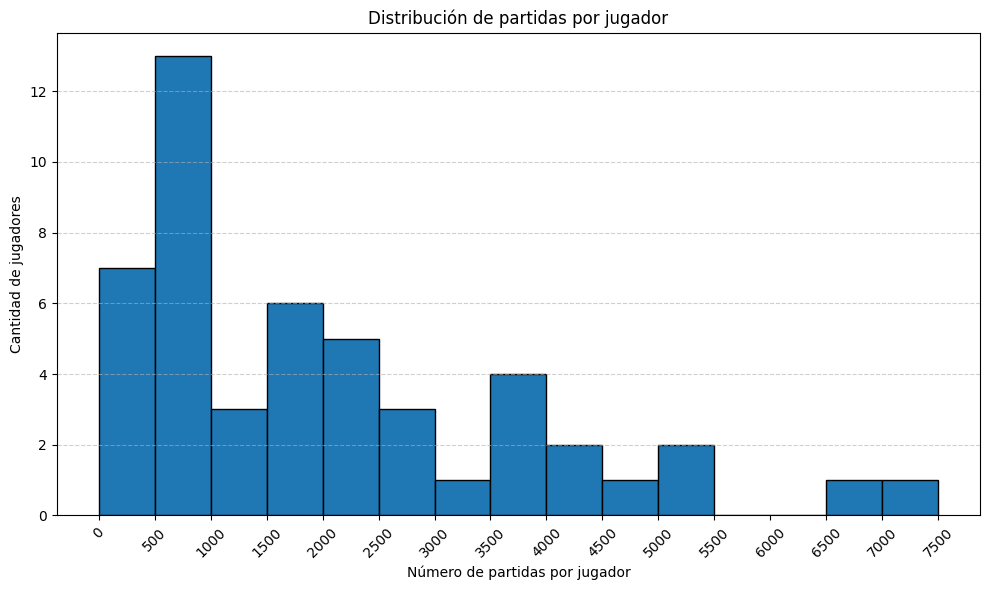

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

games = pd.read_csv("csvs/player_moves.csv")

conteo = games['player'].value_counts()



max_valor = conteo.max()
bins = np.arange(0, max_valor + 500, 500)  # Desde 0 hasta el máximo, en pasos de 500

# Paso 3: Graficar histograma
plt.figure(figsize=(10,6))
plt.hist(conteo.values, bins=bins, edgecolor='black')
plt.xlabel('Número de partidas por jugador')
plt.ylabel('Cantidad de jugadores')
plt.title('Distribución de partidas por jugador')
plt.xticks(bins, rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()